<a href="https://colab.research.google.com/github/tsparaskevas/ML_EDDE2/blob/main/Final%20essay/Final_homework_for_EDDE2_(Sentiment_Analysis_Time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**1 ---- Download / Install packages**

In [ ]:
#!python -m spacy download el_core_news_sm

###**2 ---- Import Libraries and Language (Greek)**

**Libraries**

In [ ]:
import pandas as pd
import numpy as np 

#from io import StringIO

from datetime import date
from datetime import datetime

import os
from pathlib import Path

#import glob

import re

import matplotlib.pyplot as plt

#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

%matplotlib inline

#from PIL import Image

from google.colab import drive 
drive.mount('gdrive', force_remount=True)

#from wordcloud import WordCloud, STOPWORDS

import spacy

from sklearn.feature_extraction.text import CountVectorizer

Mounted at gdrive


**Languages**

Greek

In [ ]:
gr_nlp = spacy.load('el_core_news_sm')
gr_stopwords = gr_nlp.Defaults.stop_words
print("Number of greek stopwords:", len(gr_stopwords))

Number of greek stopwords: 663


###**3 ---- Import data**

**posts**

In [ ]:
comp_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/comp_df.csv")

In [ ]:
comp_df.head(1)

,datetime,topic,source,sub_topic,full_text,clean_text,clean_text_new
0,2020-01-01 00:32:59,homocide,twitter,,@Toshir0_Mifune @kentrodexia @v_agras @nicolao...,άρα να ποινικοποιήσουμε και τη δολοφονία το...,άρα να ποινικοποιήσουμε και τη του σπέρμα...


In [ ]:
#drop duplicates and NaNs
comp_df = comp_df.drop_duplicates(subset=['clean_text_new'])
comp_df = comp_df.dropna()
comp_df.reset_index(drop=True, inplace = True)

In [ ]:
# convert datetime
comp_df['datetime'] = pd.to_datetime(comp_df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
print(comp_df.shape)
print(comp_df.dtypes)

(95062, 7)
datetime          datetime64[ns]
topic                     object
source                    object
sub_topic                 object
full_text                 object
clean_text                object
clean_text_new            object
dtype: object


**police**

In [ ]:
# import csv as dataframe
police_stats_df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/statistics2020.csv")
police_stats_df.head(1)

,Unnamed: 0,troxaio,troxaio-dead,ergatiko,Ergatiko-dead,suicide,Suicide-dead,homocide,Homocide-dead
0,Jan 2020,804,46,173,4,122,43,33,12


In [ ]:
# rename Unamed: 0 column to date
police_stats_df.rename(columns = {'Unnamed: 0':'date'}, inplace = True) 

In [ ]:
# rename columns
police_stats_df = police_stats_df.rename(columns = {'troxaio':'Tροχαία συμβάντα', 'troxaio-dead':'Νεκροί τροχαίων', 'ergatiko':'Εργατικά δυστυχήματα', 'Ergatiko-dead':'Νεκροί εργατικών δυστυχημάτων', 'suicide':'Αυτοκτονίες (απόπειρες και τελεσμένες)', 'Suicide-dead':'Νεκροί αυτοκτονιών', 'homocide':'Ανθρωποκτονίες (απόπειρες και τελεσμένες)', 'Homocide-dead':'Νεκροί ανθρωποκτονιών'})

In [ ]:
police_stats_df

,date,Tροχαία συμβάντα,Νεκροί τροχαίων,Εργατικά δυστυχήματα,Νεκροί εργατικών δυστυχημάτων,Αυτοκτονίες (απόπειρες και τελεσμένες),Νεκροί αυτοκτονιών,Ανθρωποκτονίες (απόπειρες και τελεσμένες),Νεκροί ανθρωποκτονιών
0,Jan 2020,804,46,173,4,122,43,33,12
1,Feb 2020,887,46,128,3,103,35,22,7
2,Mar 2020,520,22,100,2,87,40,18,6
3,Apr 2020,339,21,108,2,88,33,15,6
4,May 2020,747,52,142,3,92,41,24,12
5,Jun 2020,922,49,144,8,100,40,34,19
6,Jul 2020,1017,48,151,5,105,48,28,12
7,Aug 2020,903,58,149,6,111,41,31,11
8,Sep 2020,1032,63,202,6,90,39,10,4
9,Oct 2020,967,67,151,8,79,37,29,19


In [ ]:
police_stats_df.drop(12, inplace=True)

###**4 ---- Create separate dfs**

**Websites**

In [ ]:
#websites_df = comp_df[comp_df.source != 'twitter'][['datetime', 'topic', 'clean_text_new']]
#websites_df.shape

In [ ]:
# homocide
web_homo_df = comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'homocide')][['datetime', 'clean_text_new']]
web_homo_df.reset_index(drop=True, inplace=True)
web_homo_df['month'] = web_homo_df['datetime'].dt.month
# suicide
web_sui_df = comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'suicide')][['datetime', 'clean_text_new']]
web_sui_df.reset_index(drop=True, inplace=True)
web_sui_df['month'] = web_sui_df['datetime'].dt.month
# ergatiko
web_erg_df = comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'ergatiko')][['datetime', 'clean_text_new']]
web_erg_df.reset_index(drop=True, inplace=True)
web_erg_df['month'] = web_erg_df['datetime'].dt.month
# troxaio
web_tro_df = comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'troxaio')][['datetime', 'clean_text_new']]
web_tro_df.reset_index(drop=True, inplace=True)
web_tro_df['month'] = web_tro_df['datetime'].dt.month

**Twitter**

In [ ]:
#twitter_df = comp_df[comp_df.source == 'twitter'][['datetime', 'topic', 'clean_text_new']]
#twitter_df.shape

In [ ]:
# homocide
tw_homo_df = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'homocide')][['datetime', 'clean_text_new']]
tw_homo_df.reset_index(drop=True, inplace=True)
tw_homo_df['month'] = tw_homo_df['datetime'].dt.month
# suicide
tw_sui_df = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'suicide')][['datetime', 'clean_text_new']]
tw_sui_df.reset_index(drop=True, inplace=True)
tw_sui_df['month'] = tw_sui_df['datetime'].dt.month
# ergatiko
tw_erg_df = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'ergatiko')][['datetime', 'clean_text_new']]
tw_erg_df.reset_index(drop=True, inplace=True)
tw_erg_df['month'] = tw_erg_df['datetime'].dt.month
# troxaio
tw_tro_df = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'troxaio')][['datetime', 'clean_text_new']]
tw_tro_df.reset_index(drop=True, inplace=True)
tw_tro_df['month'] = tw_tro_df['datetime'].dt.month

###**5 ---- Sentiment analysis**

####**Create emolex_df and emotional words lists**

In [ ]:
# read emolex file
filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"
emolex_df = pd.read_csv(filepath)

# drop duplicates and NaNs
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(drop=True, inplace = True)

# transform to lower
emolex_df['word'] = emolex_df['word'].str.lower()

emolex_df.head(1)

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
emolex_df['word'] = emolex_df['word'].str.lower()

In [ ]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',  
                      stop_words= gr_stopwords,
                      ngram_range=(1, 2))

**Create lists with polarized emolex words** 

In [ ]:
emolex_df.columns

Index(['word', 'Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust',
       'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'],
      dtype='object')

positive/negative lists

In [ ]:
# Φτιάξε μια λίστα με positive words
positive_words = emolex_df[emolex_df.Positive == 1]['word']

# Φτιάξε μια λίστα με negative words
negative_words = emolex_df[emolex_df.Negative == 1]['word']

emotions lists

In [ ]:
# Φτιάξε μια λίστα με anger words
angry_words = emolex_df[emolex_df.Anger == 1]['word']

# Φτιάξε μια λίστα με anticipation words
anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']

# Φτιάξε μια λίστα με disgust words
disgust_words = emolex_df[emolex_df.Disgust == 1]['word']

# Φτιάξε μια λίστα με fear words
fear_words = emolex_df[emolex_df.Fear == 1]['word']

# Φτιάξε μια λίστα με joy words
joy_words = emolex_df[emolex_df.Joy == 1]['word']

# Φτιάξε μια λίστα με sadness words
sadness_words = emolex_df[emolex_df.Sadness == 1]['word']

# Φτιάξε μια λίστα με surprise words
surprise_words = emolex_df[emolex_df.Surprise == 1]['word']

# Φτιάξε μια λίστα με trust words
trust_words = emolex_df[emolex_df.Trust == 1]['word']

####**Find emolex words in corpora - websites**

**Websites - homocide**

In [ ]:
matrix = vec.fit_transform(web_homo_df['clean_text_new']) #[comp_df.source != "twitter"]
vocab = vec.get_feature_names_out()
wc_web_homo_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wc_web_homo_df.head(1)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'απο', 'αποψε', 'αρα', 'αραγε', 'αρκετα', 'αρκετες', 'αρχικα', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια', 'βεβαιοτατα', 'γιατι', 'γρηγορα', 'γυρω', 'δεινα', 'δεξια', 'δηθεν', 'δηλαδη', 'διαρκως', 'δικα', 'δικο', 'δικοι', 'δικος', 'δικου', 'δικους', 'διολου', 'διπλα', 'διχως', 'εαν', 'εαυτο', 'εαυτον', 'εαυτου', 'εαυτους', 'εαυτων', 'εγιναν', 'εγινε', 

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create columns with sentiment scores

In [ ]:
# positive/negative
web_homo_df['positivity'] = wc_web_homo_df[positive_words].sum(axis=1)
web_homo_df['negativity'] = wc_web_homo_df[negative_words].sum(axis=1)

In [ ]:
# emotions

web_homo_df['anger'] = wc_web_homo_df[angry_words].sum(axis=1)
web_homo_df['anticipation'] = wc_web_homo_df[anticipation_words].sum(axis=1)
web_homo_df['disgust'] = wc_web_homo_df[disgust_words].sum(axis=1)
web_homo_df['fear'] = wc_web_homo_df[fear_words].sum(axis=1)
web_homo_df['joy'] = wc_web_homo_df[joy_words].sum(axis=1)
web_homo_df['sadness'] = wc_web_homo_df[sadness_words].sum(axis=1)
web_homo_df['surprise'] = wc_web_homo_df[surprise_words].sum(axis=1)
web_homo_df['trust'] = wc_web_homo_df[trust_words].sum(axis=1)

**Websites - suicide**

In [ ]:
matrix = vec.fit_transform(web_sui_df['clean_text_new']) #[comp_df.source != "twitter"]
vocab = vec.get_feature_names_out()
wc_web_sui_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wc_web_sui_df.head(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create columns with sentiment scores

In [ ]:
# positive/negative
web_sui_df['positivity'] = wc_web_sui_df[positive_words].sum(axis=1)
web_sui_df['negativity'] = wc_web_sui_df[negative_words].sum(axis=1)

In [ ]:
# emotions

web_sui_df['anger'] = wc_web_sui_df[angry_words].sum(axis=1)
web_sui_df['anticipation'] = wc_web_sui_df[anticipation_words].sum(axis=1)
web_sui_df['disgust'] = wc_web_sui_df[disgust_words].sum(axis=1)
web_sui_df['fear'] = wc_web_sui_df[fear_words].sum(axis=1)
web_sui_df['joy'] = wc_web_sui_df[joy_words].sum(axis=1)
web_sui_df['sadness'] = wc_web_sui_df[sadness_words].sum(axis=1)
web_sui_df['surprise'] = wc_web_sui_df[surprise_words].sum(axis=1)
web_sui_df['trust'] = wc_web_sui_df[trust_words].sum(axis=1)

**Websites - ergatiko**

In [ ]:
matrix = vec.fit_transform(web_erg_df['clean_text_new']) #[comp_df.source != "twitter"]
vocab = vec.get_feature_names_out()
wc_web_erg_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wc_web_erg_df.head(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create columns with sentiment scores

In [ ]:
# positive/negative
web_erg_df['positivity'] = wc_web_erg_df[positive_words].sum(axis=1)
web_erg_df['negativity'] = wc_web_erg_df[negative_words].sum(axis=1)

In [ ]:
# emotions

web_erg_df['anger'] = wc_web_erg_df[angry_words].sum(axis=1)
web_erg_df['anticipation'] = wc_web_erg_df[anticipation_words].sum(axis=1)
web_erg_df['disgust'] = wc_web_erg_df[disgust_words].sum(axis=1)
web_erg_df['fear'] = wc_web_erg_df[fear_words].sum(axis=1)
web_erg_df['joy'] = wc_web_erg_df[joy_words].sum(axis=1)
web_erg_df['sadness'] = wc_web_erg_df[sadness_words].sum(axis=1)
web_erg_df['surprise'] = wc_web_erg_df[surprise_words].sum(axis=1)
web_erg_df['trust'] = wc_web_erg_df[trust_words].sum(axis=1)

**Websites - troxaio**

In [ ]:
matrix = vec.fit_transform(web_tro_df['clean_text_new']) #[comp_df.source != "twitter"]
vocab = vec.get_feature_names_out()
wc_web_tro_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wc_web_tro_df.head(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create columns with sentiment scores

In [ ]:
# positive/negative
web_tro_df['positivity'] = wc_web_tro_df[positive_words].sum(axis=1)
web_tro_df['negativity'] = wc_web_tro_df[negative_words].sum(axis=1)

In [ ]:
# emotions

web_tro_df['anger'] = wc_web_tro_df[angry_words].sum(axis=1)
web_tro_df['anticipation'] = wc_web_tro_df[anticipation_words].sum(axis=1)
web_tro_df['disgust'] = wc_web_tro_df[disgust_words].sum(axis=1)
web_tro_df['fear'] = wc_web_tro_df[fear_words].sum(axis=1)
web_tro_df['joy'] = wc_web_tro_df[joy_words].sum(axis=1)
web_tro_df['sadness'] = wc_web_tro_df[sadness_words].sum(axis=1)
web_tro_df['surprise'] = wc_web_tro_df[surprise_words].sum(axis=1)
web_tro_df['trust'] = wc_web_tro_df[trust_words].sum(axis=1)

####**Find emolex words in corpora - twitter**

**Twitter - homocide**

In [ ]:
matrix = vec.fit_transform(tw_homo_df['clean_text_new']) #[comp_df.source != "twitter"]
vocab = vec.get_feature_names_out()
wc_tw_homo_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wc_tw_homo_df.head(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create columns with sentiment scores

In [ ]:
# positive/negative
tw_homo_df['positivity'] = wc_tw_homo_df[positive_words].sum(axis=1)
tw_homo_df['negativity'] = wc_tw_homo_df[negative_words].sum(axis=1)

In [ ]:
# emotions

tw_homo_df['anger'] = wc_tw_homo_df[angry_words].sum(axis=1)
tw_homo_df['anticipation'] = wc_tw_homo_df[anticipation_words].sum(axis=1)
tw_homo_df['disgust'] = wc_tw_homo_df[disgust_words].sum(axis=1)
tw_homo_df['fear'] = wc_tw_homo_df[fear_words].sum(axis=1)
tw_homo_df['joy'] = wc_tw_homo_df[joy_words].sum(axis=1)
tw_homo_df['sadness'] = wc_tw_homo_df[sadness_words].sum(axis=1)
tw_homo_df['surprise'] = wc_tw_homo_df[surprise_words].sum(axis=1)
tw_homo_df['trust'] = wc_tw_homo_df[trust_words].sum(axis=1)

**Twitter - suicide**

In [ ]:
matrix = vec.fit_transform(tw_sui_df['clean_text_new']) #[comp_df.source != "twitter"]
vocab = vec.get_feature_names_out()
wc_tw_sui_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wc_tw_sui_df.head(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create columns with sentiment scores

In [ ]:
# positive/negative
tw_sui_df['positivity'] = wc_tw_sui_df[positive_words].sum(axis=1)
tw_sui_df['negativity'] = wc_tw_sui_df[negative_words].sum(axis=1)

In [ ]:
# emotions

tw_sui_df['anger'] = wc_tw_sui_df[angry_words].sum(axis=1)
tw_sui_df['anticipation'] = wc_tw_sui_df[anticipation_words].sum(axis=1)
tw_sui_df['disgust'] = wc_tw_sui_df[disgust_words].sum(axis=1)
tw_sui_df['fear'] = wc_tw_sui_df[fear_words].sum(axis=1)
tw_sui_df['joy'] = wc_tw_sui_df[joy_words].sum(axis=1)
tw_sui_df['sadness'] = wc_tw_sui_df[sadness_words].sum(axis=1)
tw_sui_df['surprise'] = wc_tw_sui_df[surprise_words].sum(axis=1)
tw_sui_df['trust'] = wc_tw_sui_df[trust_words].sum(axis=1)

**Twitter - ergatiko**

In [ ]:
matrix = vec.fit_transform(tw_erg_df['clean_text_new']) #[comp_df.source != "twitter"]
vocab = vec.get_feature_names_out()
wc_tw_erg_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wc_tw_erg_df.head(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create columns with sentiment scores

In [ ]:
# positive/negative
tw_erg_df['positivity'] = wc_tw_erg_df[positive_words].sum(axis=1)
tw_erg_df['negativity'] = wc_tw_erg_df[negative_words].sum(axis=1)

In [ ]:
# emotions

tw_erg_df['anger'] = wc_tw_erg_df[angry_words].sum(axis=1)
tw_erg_df['anticipation'] = wc_tw_erg_df[anticipation_words].sum(axis=1)
tw_erg_df['disgust'] = wc_tw_erg_df[disgust_words].sum(axis=1)
tw_erg_df['fear'] = wc_tw_erg_df[fear_words].sum(axis=1)
tw_erg_df['joy'] = wc_tw_erg_df[joy_words].sum(axis=1)
tw_erg_df['sadness'] = wc_tw_erg_df[sadness_words].sum(axis=1)
tw_erg_df['surprise'] = wc_tw_erg_df[surprise_words].sum(axis=1)
tw_erg_df['trust'] = wc_tw_erg_df[trust_words].sum(axis=1)

**Twitter - troxaio**

In [ ]:
matrix = vec.fit_transform(tw_tro_df['clean_text_new']) #[comp_df.source != "twitter"]
vocab = vec.get_feature_names_out()
wc_tw_tro_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wc_tw_tro_df.head(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create columns with sentiment scores

In [ ]:
# positive/negative
tw_tro_df['positivity'] = wc_tw_tro_df[positive_words].sum(axis=1)
tw_tro_df['negativity'] = wc_tw_tro_df[negative_words].sum(axis=1)

In [ ]:
# emotions

tw_tro_df['anger'] = wc_tw_tro_df[angry_words].sum(axis=1)
tw_tro_df['anticipation'] = wc_tw_tro_df[anticipation_words].sum(axis=1)
tw_tro_df['disgust'] = wc_tw_tro_df[disgust_words].sum(axis=1)
tw_tro_df['fear'] = wc_tw_tro_df[fear_words].sum(axis=1)
tw_tro_df['joy'] = wc_tw_tro_df[joy_words].sum(axis=1)
tw_tro_df['sadness'] = wc_tw_tro_df[sadness_words].sum(axis=1)
tw_tro_df['surprise'] = wc_tw_tro_df[surprise_words].sum(axis=1)
tw_tro_df['trust'] = wc_tw_tro_df[trust_words].sum(axis=1)

###**Timeseries graphs for stats**

####**Websites**

**websites homocide**

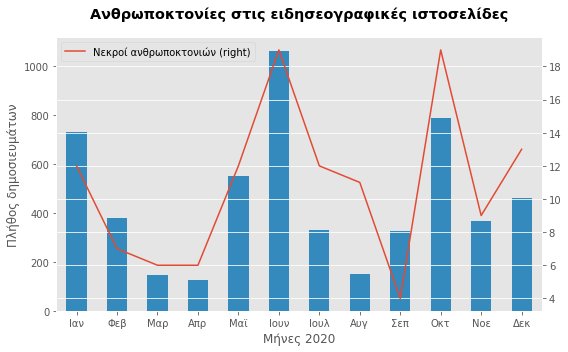

In [ ]:
# websites homocide articles per month
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = web_homo_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#348ABD', ylabel = 'Πλήθος δημοσιευμάτων', xlabel = "Μήνες 2020")
police_stats_df['Νεκροί ανθρωποκτονιών'].plot(secondary_y=True).legend()
plt.title('Ανθρωποκτονίες στις ειδησεογραφικές ιστοσελίδες', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

**websites suicide**

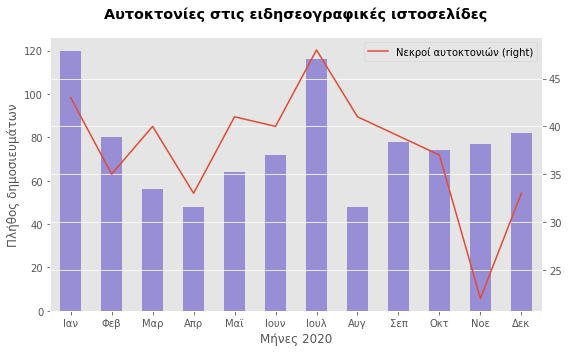

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = web_sui_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#988ED5', ylabel = 'Πλήθος δημοσιευμάτων', xlabel = "Μήνες 2020")
police_stats_df['Νεκροί αυτοκτονιών'].plot(secondary_y=True).legend()
plt.title('Αυτοκτονίες στις ειδησεογραφικές ιστοσελίδες', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

**websites ergatiko**

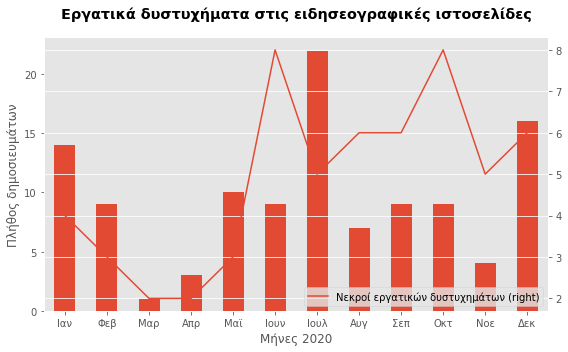

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = web_erg_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#E24A33', ylabel = 'Πλήθος δημοσιευμάτων', xlabel = "Μήνες 2020")
police_stats_df['Νεκροί εργατικών δυστυχημάτων'].plot(secondary_y=True).legend()
plt.title('Εργατικά δυστυχήματα στις ειδησεογραφικές ιστοσελίδες', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

**websites troxaio**

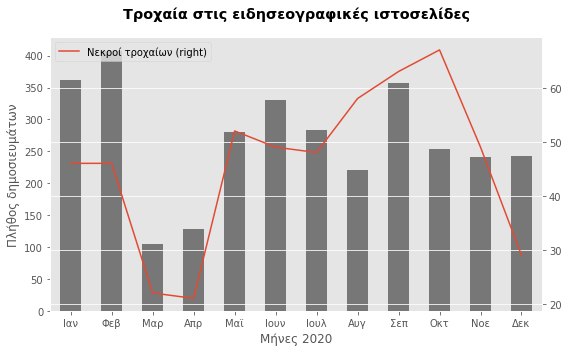

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = web_tro_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#777777', ylabel = 'Πλήθος δημοσιευμάτων', xlabel = "Μήνες 2020")
police_stats_df['Νεκροί τροχαίων'].plot(secondary_y=True).legend()
plt.title('Τροχαία στις ειδησεογραφικές ιστοσελίδες', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

####**Twitter**

**twitter homocide**

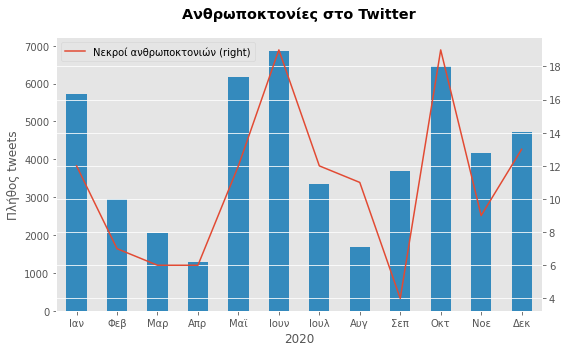

In [ ]:
# twitter homocide articles per month
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = tw_homo_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#348ABD', ylabel = 'Πλήθος tweets', xlabel = "2020")
police_stats_df['Νεκροί ανθρωποκτονιών'].plot(secondary_y=True).legend()
plt.title('Ανθρωποκτονίες στο Twitter', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

**twitter suicide**

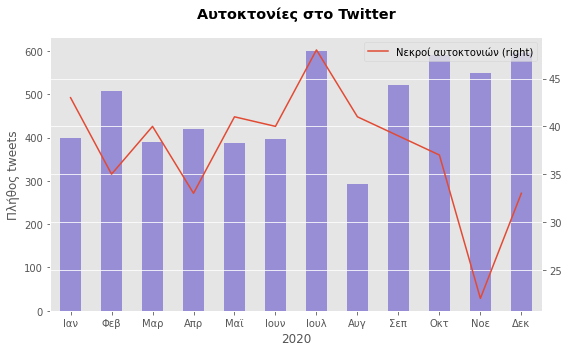

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = tw_sui_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#988ED5', ylabel = 'Πλήθος tweets', xlabel = "2020")
police_stats_df['Νεκροί αυτοκτονιών'].plot(secondary_y=True).legend()
plt.title('Αυτοκτονίες στο Twitter', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

**twitter ergatiko**

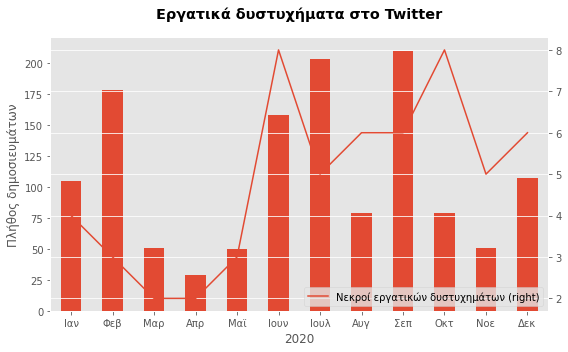

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = tw_erg_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#E24A33', ylabel = 'Πλήθος δημοσιευμάτων', xlabel = "2020")
police_stats_df['Νεκροί εργατικών δυστυχημάτων'].plot(secondary_y=True).legend()
plt.title('Εργατικά δυστυχήματα στο Twitter', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

**twitter troxaio**

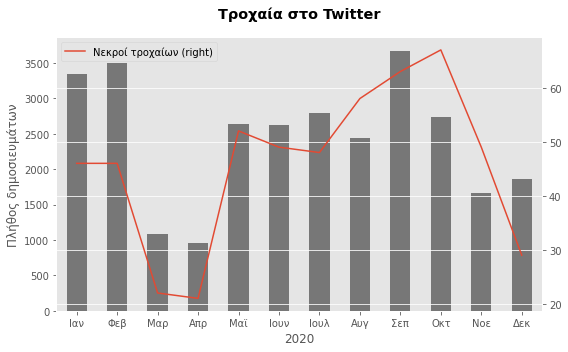

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = tw_tro_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#777777', ylabel = 'Πλήθος δημοσιευμάτων', xlabel = "2020")
police_stats_df['Νεκροί τροχαίων'].plot(secondary_y=True).legend()
plt.title('Τροχαία στο Twitter', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

####**Websites & Twitter & Police stats**

**homocide**

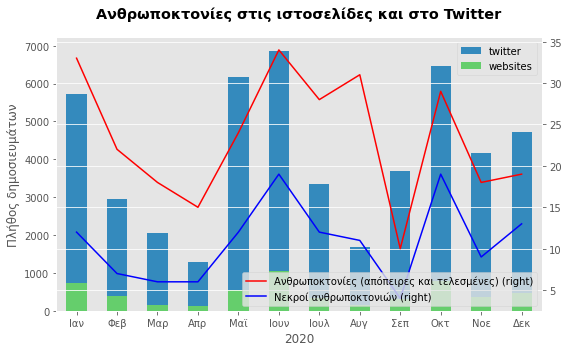

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = tw_homo_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#348ABD', label = "twitter")
web_homo_df.groupby('month')['clean_text_new'].count().plot(kind='bar', ax=ax, color = '#65ce6c', label = "websites").legend()
police_stats_df['Ανθρωποκτονίες (απόπειρες και τελεσμένες)'].plot(secondary_y=True, color = "r").legend()
police_stats_df['Νεκροί ανθρωποκτονιών'].plot(secondary_y=True, color = "b", xlabel="2020", ylabel = "Πλήθος δημοσιευμάτων").legend()
plt.title('Ανθρωποκτονίες στις ιστοσελίδες και στο Twitter', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

**twitter suicide**

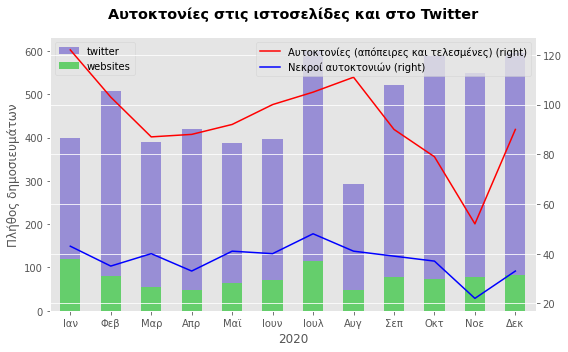

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = tw_sui_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#988ED5', label = "twitter")
web_sui_df.groupby('month')['clean_text_new'].count().plot(kind='bar', ax=ax, color = '#65ce6c', label = "websites").legend()
police_stats_df['Αυτοκτονίες (απόπειρες και τελεσμένες)'].plot(secondary_y=True, color = "r").legend()
police_stats_df['Νεκροί αυτοκτονιών'].plot(secondary_y=True, color = "b", xlabel="2020", ylabel = "Πλήθος δημοσιευμάτων").legend()
plt.title('Αυτοκτονίες στις ιστοσελίδες και στο Twitter', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

**twitter ergatiko**

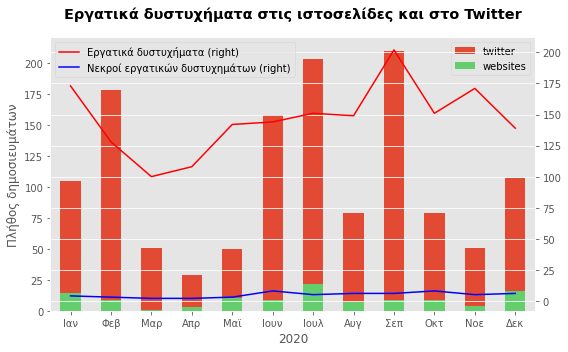

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = tw_erg_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#E24A33', label = "twitter")
web_erg_df.groupby('month')['clean_text_new'].count().plot(kind='bar', ax=ax, color = '#65ce6c', label = "websites").legend()
police_stats_df['Εργατικά δυστυχήματα'].plot(secondary_y=True, color = "r").legend()
police_stats_df['Νεκροί εργατικών δυστυχημάτων'].plot(secondary_y=True, xlabel="2020", color = "b", ylabel = "Πλήθος δημοσιευμάτων").legend()
plt.title('Εργατικά δυστυχήματα στις ιστοσελίδες και στο Twitter', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

**twitter troxaio**

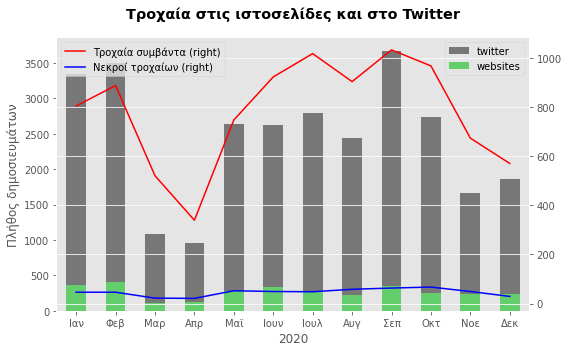

In [ ]:
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
ax = tw_tro_df.groupby('month')['clean_text_new'].count().plot(kind='bar', figsize=(8,5), color = '#777777', label = "twitter")
web_tro_df.groupby('month')['clean_text_new'].count().plot(kind='bar', ax=ax, color = '#65ce6c', label = "websites").legend()
police_stats_df['Tροχαία συμβάντα'].plot(secondary_y=True, color = "r").legend()
police_stats_df['Νεκροί τροχαίων'].plot(secondary_y=True, xlabel="2020", color = "b", ylabel = "Πλήθος δημοσιευμάτων").legend()
plt.title('Τροχαία στις ιστοσελίδες και στο Twitter', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

####**Words statistics**

**Μ.Ο. λέξεων των δημοσιευμάτων, ανά θεματική, ανά μήνα**

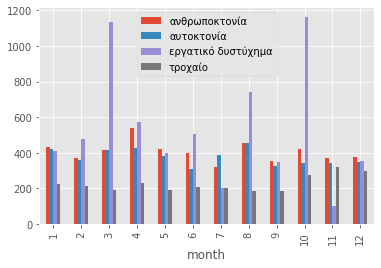

In [ ]:
w_homo = web_homo_df['clean_text_new'].str.split().str.len().groupby(by=web_homo_df['month']).mean()
w_sui = web_sui_df['clean_text_new'].str.split().str.len().groupby(by=web_sui_df['month']).mean()
w_erg = web_erg_df['clean_text_new'].str.split().str.len().groupby(by=web_erg_df['month']).mean()
w_tro = web_tro_df['clean_text_new'].str.split().str.len().groupby(by=web_tro_df['month']).mean()
pd.concat([w_homo, w_sui, w_erg, w_tro],keys=['ανθρωποκτονία', 'αυτοκτονία', 'εργατικό δυστύχημα', 'τροχαίο']).unstack(0).plot(kind='bar')

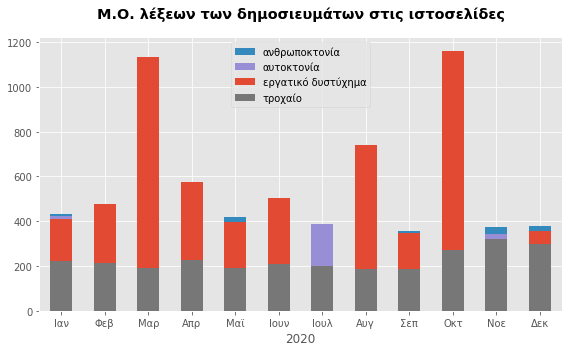

In [ ]:
# mean of posts' length sent per month
fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777']
#ax = plt.subplot(111)

ax = web_homo_df['clean_text_new'].str.split().str.len().groupby(by=web_homo_df['month']).mean().plot(kind='bar', figsize=(8,5), color = '#348ABD', label='ανθρωποκτονία')
web_sui_df['clean_text_new'].str.split().str.len().groupby(by=web_sui_df['month']).mean().plot(kind='bar', ax=ax, color = '#988ED5', label='αυτοκτονία')
web_erg_df['clean_text_new'].str.split().str.len().groupby(by=web_erg_df['month']).mean().plot(kind='bar', ax=ax, color = '#E24A33', label='εργατικό δυστύχημα')
web_tro_df['clean_text_new'].str.split().str.len().groupby(by=web_tro_df['month']).mean().plot(kind='bar', ax=ax, color = '#777777', label='τροχαίο').legend()
plt.xlabel("2020")
plt.title('Μ.Ο. λέξεων των δημοσιευμάτων στις ιστοσελίδες', y=1.05, fontweight='bold')
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.xticks(rotation=0)
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/mean-of-tweets-length-sent-per-hour.png')

###**Time series graphs for emotions**

In [ ]:
# set datetime as index - websites
web_homo_df_dt = web_homo_df.set_index('datetime')
web_sui_df_dt = web_sui_df.set_index('datetime')
web_erg_df_dt = web_erg_df.set_index('datetime')
web_tro_df_dt = web_tro_df.set_index('datetime')
# set datetime as index - twitter
tw_homo_df_dt = tw_homo_df.set_index('datetime')
tw_sui_df_dt = tw_sui_df.set_index('datetime')
tw_erg_df_dt = tw_erg_df.set_index('datetime')
tw_tro_df_dt = tw_tro_df.set_index('datetime')

####**Websites - negative emotions**

<Figure size 432x288 with 0 Axes>

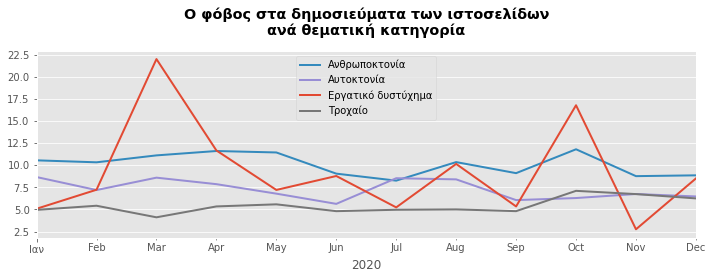

In [ ]:
# fear in websites
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = web_homo_df_dt[['fear']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
web_sui_df_dt[['fear']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
web_erg_df_dt[['fear']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
web_tro_df_dt[['fear']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Ο φόβος στα δημοσιεύματα των ιστοσελίδων\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

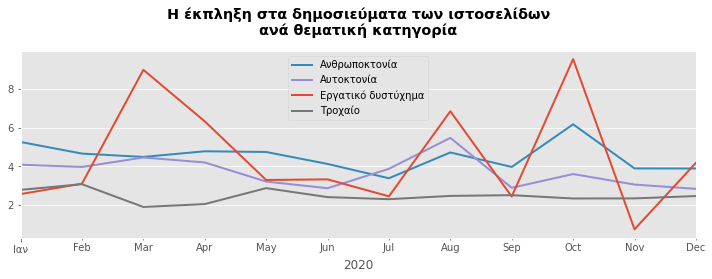

In [ ]:
# surprise in websites
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = web_homo_df_dt[['surprise']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
web_sui_df_dt[['surprise']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
web_erg_df_dt[['surprise']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
web_tro_df_dt[['surprise']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Η έκπληξη στα δημοσιεύματα των ιστοσελίδων\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

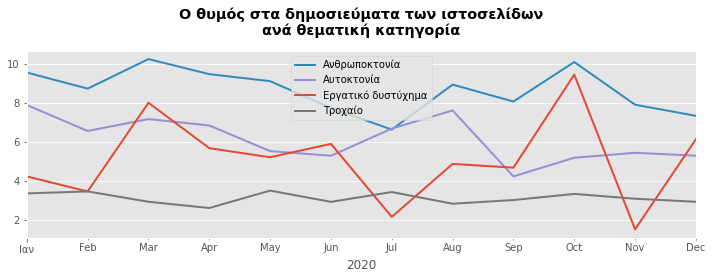

In [ ]:
# anger in websites
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = web_homo_df_dt[['anger']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
web_sui_df_dt[['anger']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
web_erg_df_dt[['anger']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
web_tro_df_dt[['anger']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Ο θυμός στα δημοσιεύματα των ιστοσελίδων\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

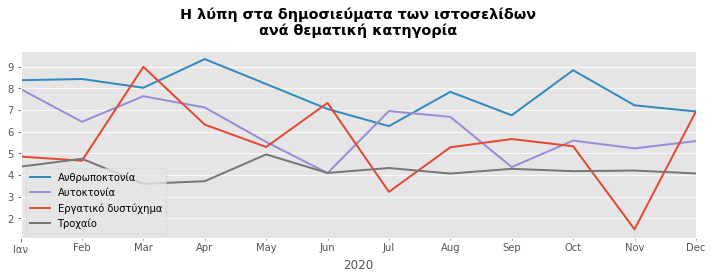

In [ ]:
# sadness in websites
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = web_homo_df_dt[['sadness']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
web_sui_df_dt[['sadness']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
web_erg_df_dt[['sadness']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
web_tro_df_dt[['sadness']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Η λύπη στα δημοσιεύματα των ιστοσελίδων\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

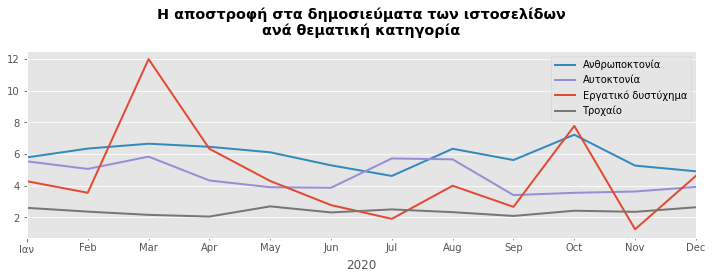

In [ ]:
# disgust in websites
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = web_homo_df_dt[['disgust']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
web_sui_df_dt[['disgust']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
web_erg_df_dt[['disgust']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
web_tro_df_dt[['disgust']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Η αποστροφή στα δημοσιεύματα των ιστοσελίδων\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

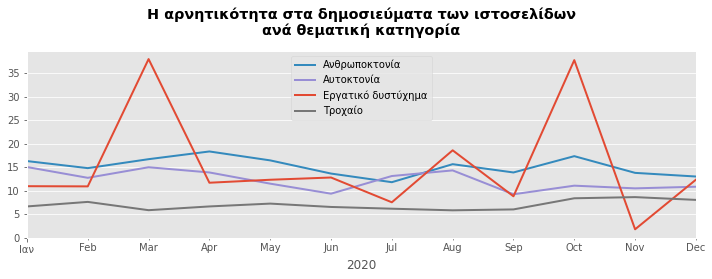

In [ ]:
# negativity in websites
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = web_homo_df_dt[['negativity']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
web_sui_df_dt[['negativity']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
web_erg_df_dt[['negativity']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
web_tro_df_dt[['negativity']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Η αρνητικότητα στα δημοσιεύματα των ιστοσελίδων\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

####**Twitter - negative emotions**

<Figure size 432x288 with 0 Axes>

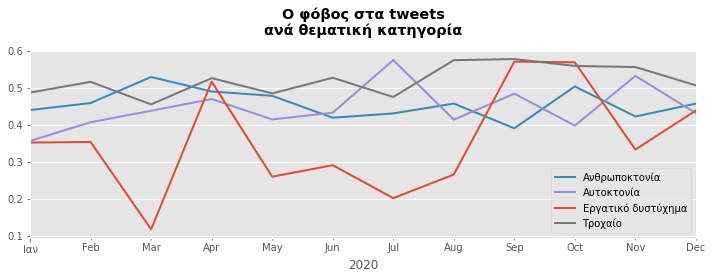

In [ ]:
# fear in Twitter
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = tw_homo_df_dt[['fear']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
tw_sui_df_dt[['fear']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
tw_erg_df_dt[['fear']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
tw_tro_df_dt[['fear']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Ο φόβος στα tweets\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

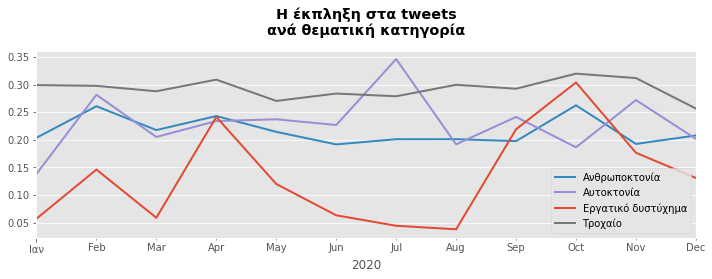

In [ ]:
# surprise in Twitter
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = tw_homo_df_dt[['surprise']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
tw_sui_df_dt[['surprise']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
tw_erg_df_dt[['surprise']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
tw_tro_df_dt[['surprise']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Η έκπληξη στα tweets\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

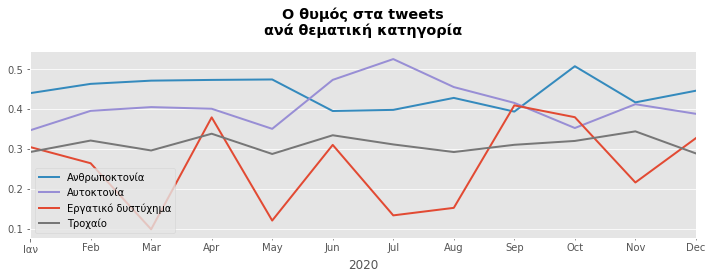

In [ ]:
# anger in Twitter
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = tw_homo_df_dt[['anger']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
tw_sui_df_dt[['anger']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
tw_erg_df_dt[['anger']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
tw_tro_df_dt[['anger']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Ο θυμός στα tweets\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

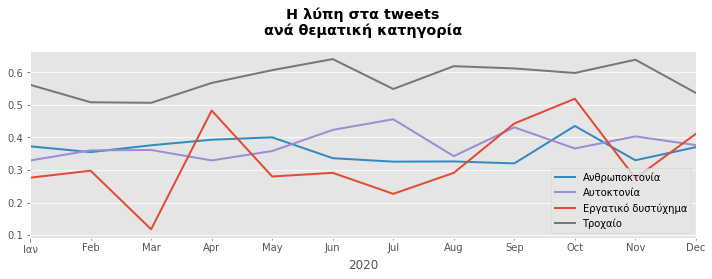

In [ ]:
# sadness in Twitter
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = tw_homo_df_dt[['sadness']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
tw_sui_df_dt[['sadness']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
tw_erg_df_dt[['sadness']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
tw_tro_df_dt[['sadness']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Η λύπη στα tweets\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

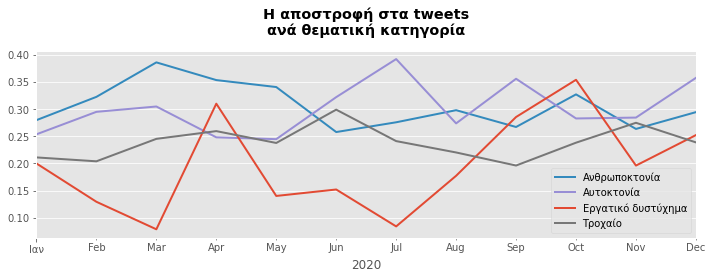

In [ ]:
# disgust in Twitter
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = tw_homo_df_dt[['disgust']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
tw_sui_df_dt[['disgust']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
tw_erg_df_dt[['disgust']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
tw_tro_df_dt[['disgust']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Η αποστροφή στα tweets\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

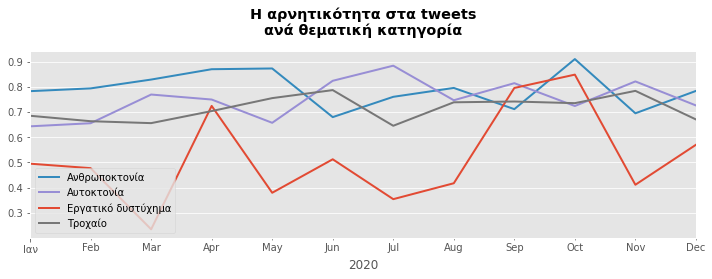

In [ ]:
# negativity in Twitter
fig=plt.figure()
my_colors = ['#348ABD', '#988ED5', '#E24A33', '#777777']
mylabels = ["Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό δυστύχημα", "Τροχαίο"]
ax = tw_homo_df_dt[['negativity']].resample('M').mean().plot(figsize=(10,4), color=my_colors[0], linewidth=2.0)
tw_sui_df_dt[['negativity']].resample('M').mean().plot(ax=ax, color=my_colors[1], linewidth=2.0)
tw_erg_df_dt[['negativity']].resample('M').mean().plot(ax=ax, color=my_colors[2], linewidth=2.0)
tw_tro_df_dt[['negativity']].resample('M').mean().plot(ax=ax, color=my_colors[3], linewidth=2.0)
plt.xlabel("2020")
plt.title('Η αρνητικότητα στα tweets\nανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
ax.set_xticklabels(('Ιαν', 'Φεβ', 'Μαρ', 'Απρ', 'Μαϊ', 'Ιουν', 'Ιουλ', 'Αυγ', 'Σεπ', 'Οκτ', 'Νοε', 'Δεκ'))
plt.tight_layout()